## test 1: reproducing known simulation map from noise + mock data 
(see constant tutorial for methods)
* working on flat-sky (healpy) 
* mock data is of higher resolution than the known simulation map --> must reduce
* note also when working with real planck observations we need conversion factor to go from  to $K_{CMB}$
* looking at 100, 143 GHz
* chameleon constellation

In [16]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import glob
from tools import *

In [17]:
dir_sim = '../CO_sims/'
dir_data = '../realdata/'

### map of full-sky planck CO map

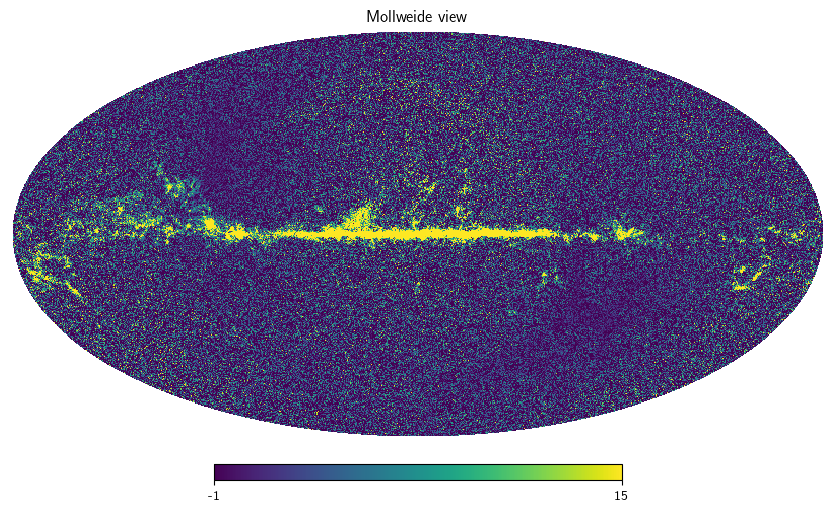

In [18]:
# show full-sky map of real planck CO map
file_in = dir_data + 'map_CO12_100-143_from_100x143_DATA_R1_gold+hlat_new_full_nsideI2048_nsideQU256_nsideCO1024.dat'
planck12CO = np.fromfile(file_in)
hp.mollview(planck12CO,max=15.,min=-1.)
plt.show()

### flat-sky map of planck CO data: chameleon constellation

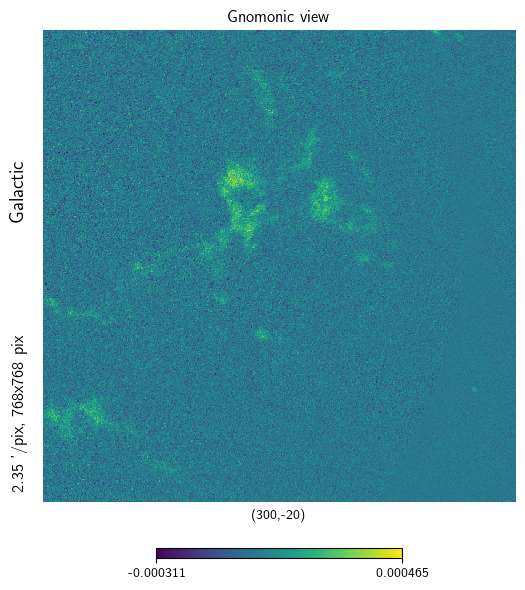

In [19]:
# extract flat-sky image
fac_12CO = 1.48e-5 # scaling from K km/s to K CMB 
# ^ page 267 these de clement appendix D-1, average of 8 bolometers 

# Galactic coordinates of image center
glon = 300.
glat =-20.
# pixel size arcminutes
pix_arcmin = 2.35
# image size
Nx = 768
Ny = 768
# return numpy array of the image in K km/s
CO = hp.gnomview(planck12CO*fac_12CO,coord='G',rot=[glon,glat],reso=pix_arcmin,xsize=Nx,ysize=Ny,return_projected_map=True)
plt.show()


### model of CO to retrieve: exclusively CO signal (no noise)

(196608,)


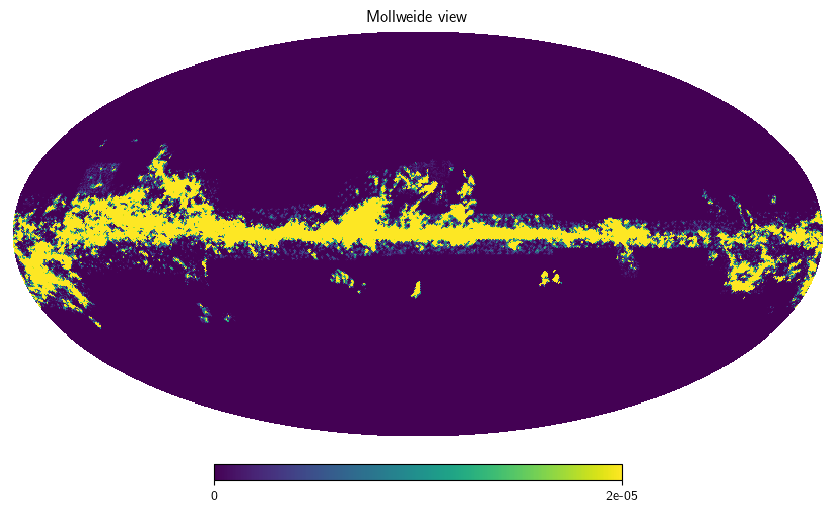

In [20]:
# CO input model used in Simulations

# read input 12CO(1-0) healpix image Nside=128
file_path = dir_sim + '12COforSIMU.float32.bin'
with open(file_path, 'rb') as f:
    # Read the binary data from the file
    binary_data = f.read()

model12CO = np.frombuffer(binary_data, dtype=np.float32)
print(model12CO.shape)
hp.mollview(model12CO, max=2e-5, min=0) # end to end simulation map (1) no noise

In [21]:
f0 = dir_sim + 'map_CO12_100-143_from_100x143_000_R1_gold+hlat_new_nsideI2048_nsideQU256_nsideCO1024.dat'
f1 = dir_sim + 'map_CO12_100-143_from_100x143_000_R1_gold+hlat_new_hm1_nsideI2048_nsideQU256_nsideCO1024.dat'
f2 = dir_sim + 'map_CO12_100-143_from_100x143_000_R1_gold+hlat_new_hm2_nsideI2048_nsideQU256_nsideCO1024.dat'
map0 = np.fromfile(f0)
map1 = np.fromfile(f1)
map2 = np.fromfile(f2)



In [22]:
def up_grade(im,onside,FWHM=20./60./180.*np.pi):
        # function to eventually use to change resolution when we move to using real data (?)
        th,ph=hp.pix2ang(onside,np.arange(12*onside*onside))
        val=hp.get_interp_val(im,th,ph)
        val=hp.smoothing(val,FWHM)
        return(val)

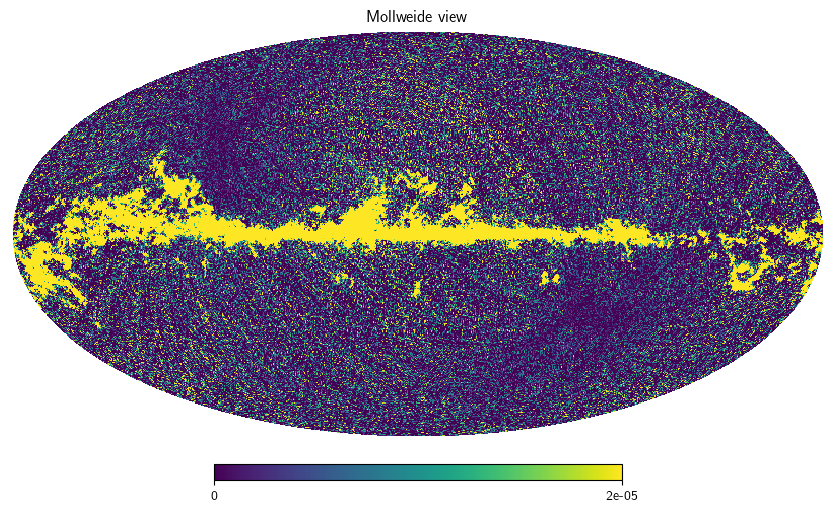

In [23]:
map0_128 = hp.ud_grade(map0,128,order_out='RING')
map1_128 = hp.ud_grade(map1,128,order_out='RING')
map2_128 = hp.ud_grade(map2,128,order_out='RING')
dif0 = map0_128 - model12CO

hp.mollview(map0_128, max=2e-5,min=0) # systematic effect -- won't be able to get correct CO from center 

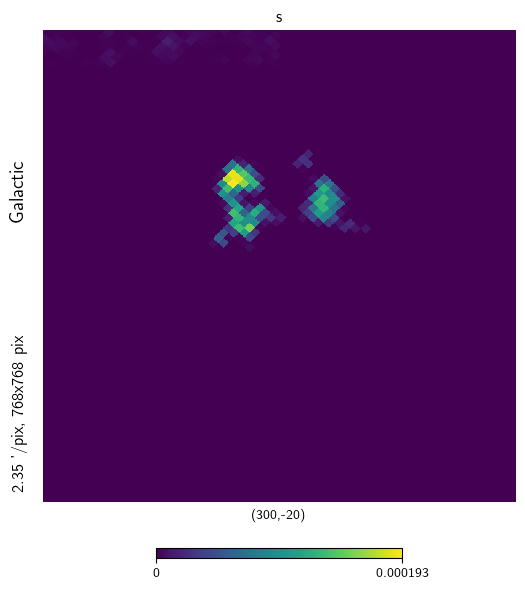

(768, 768)


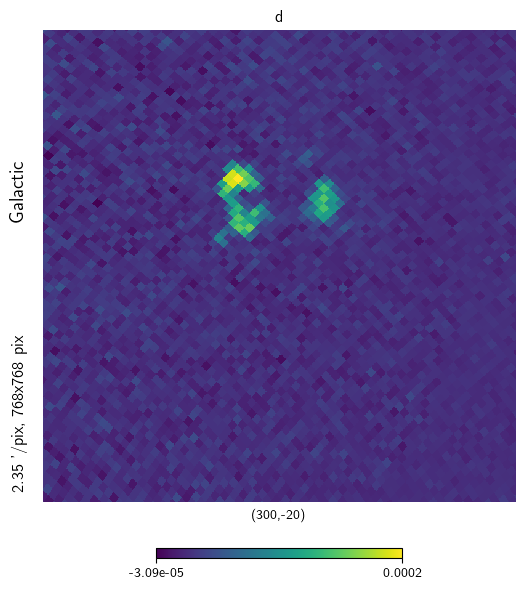

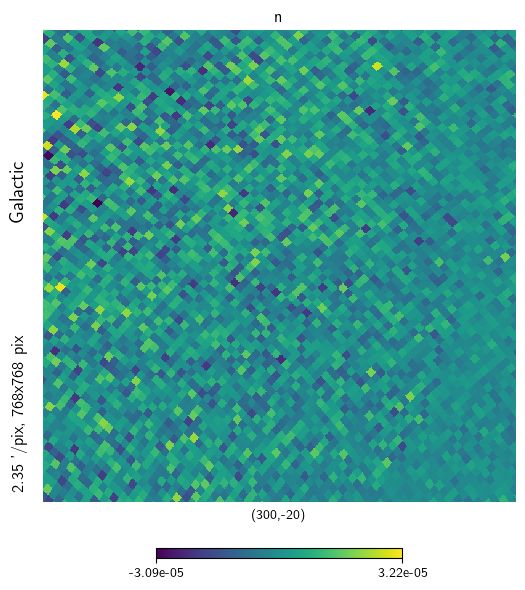

In [32]:
s = hp.gnomview(model12CO,coord='G',rot=[glon,glat],reso=pix_arcmin,xsize=Nx,ysize=Ny,return_projected_map=True) # noiseless model: s
plt.title('s')
plt.show()
s_filled = s.filled(np.nan)
np.save('../CO_sims/s.npy', s_filled)
print(s.shape)

CO = hp.gnomview(map0_128,coord='G',rot=[glon,glat],reso=pix_arcmin,xsize=Nx,ysize=Ny,return_projected_map=True) # noisy mock data: d
plt.title('d')
plt.show()

dif = map0_128 - model12CO

n1 = hp.gnomview(dif,coord='G',rot=[glon,glat],reso=pix_arcmin,xsize=Nx,ysize=Ny,return_projected_map=True) # just noise, no CO: note systematic thing there
plt.title('n')
plt.show()

(10, 768, 768)


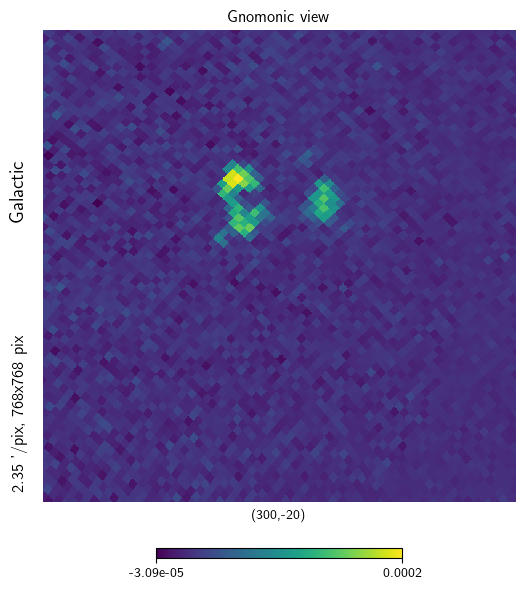

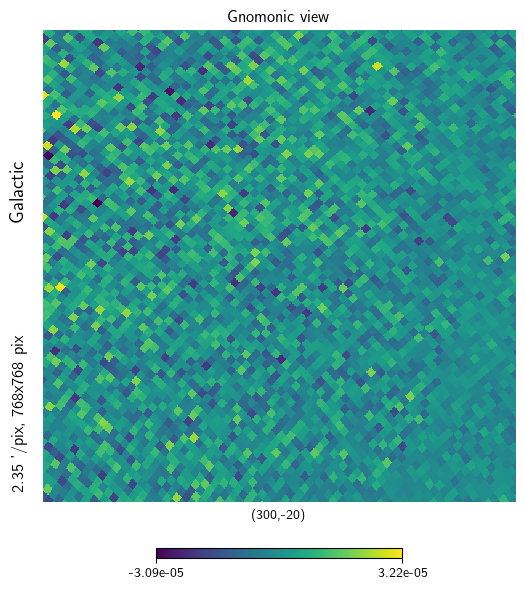

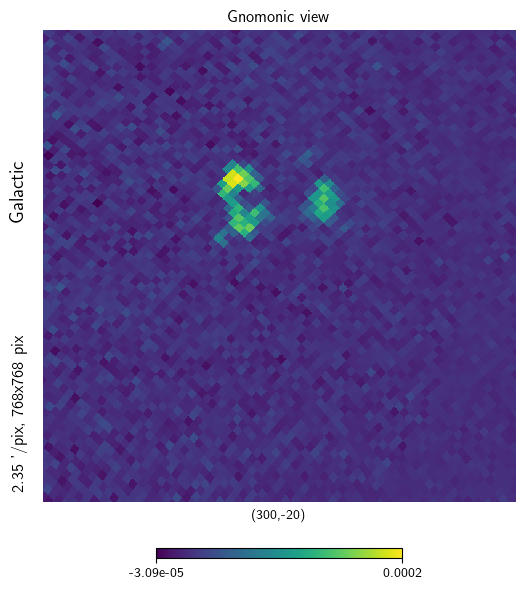

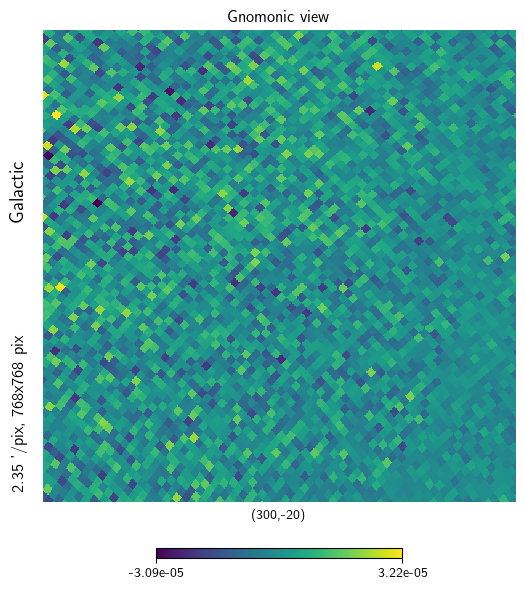

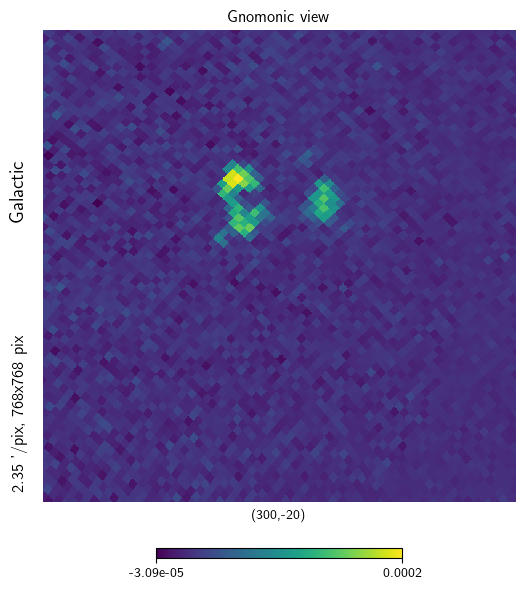

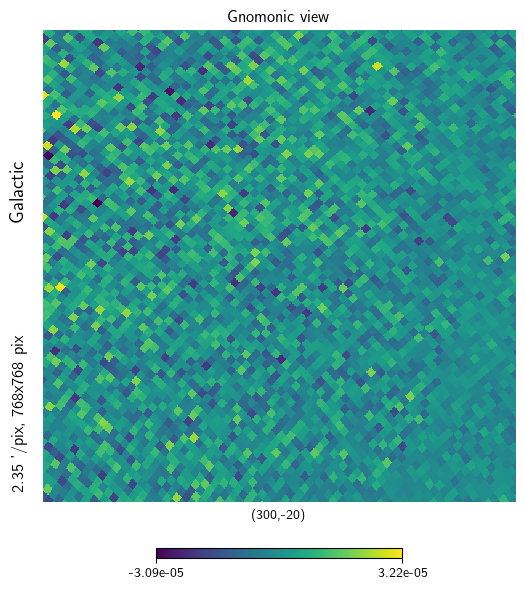

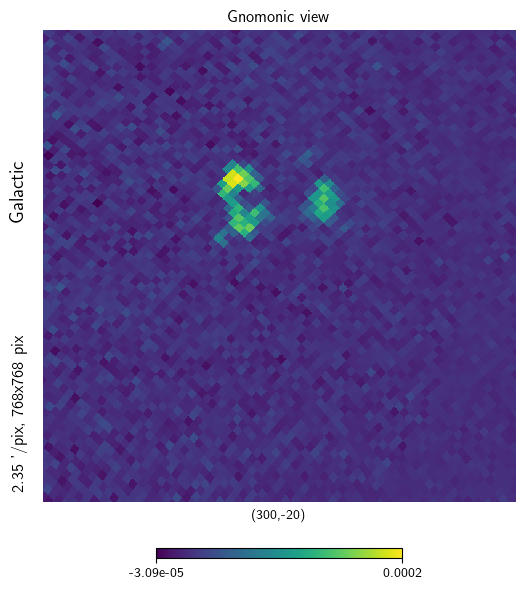

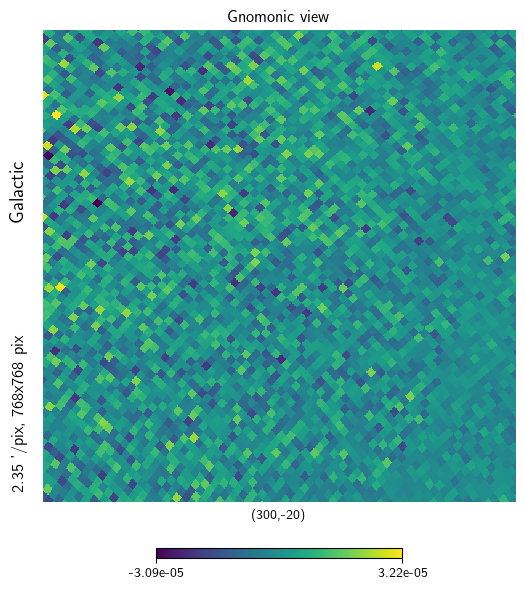

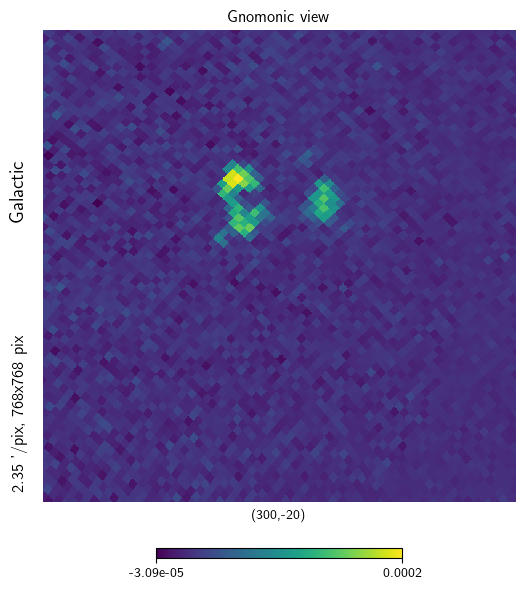

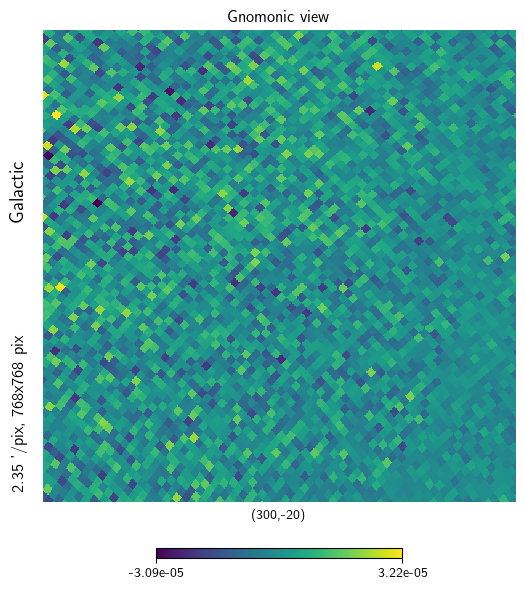

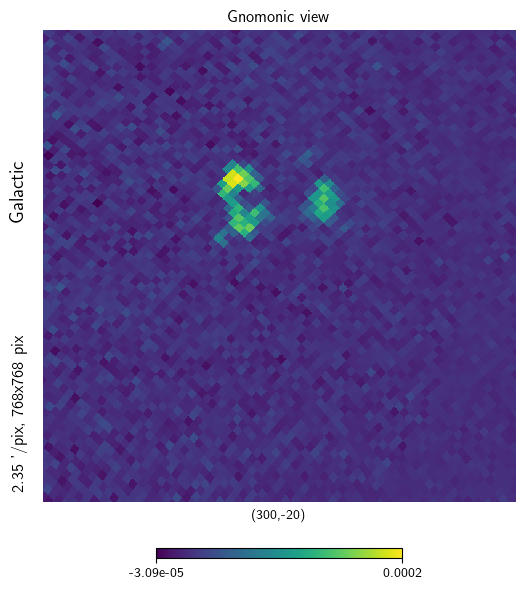

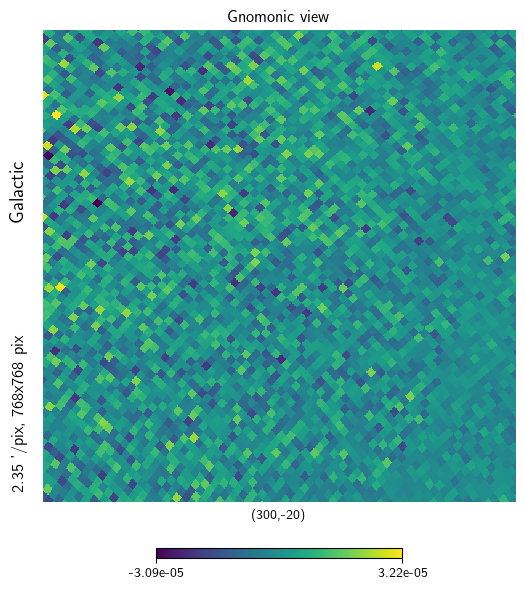

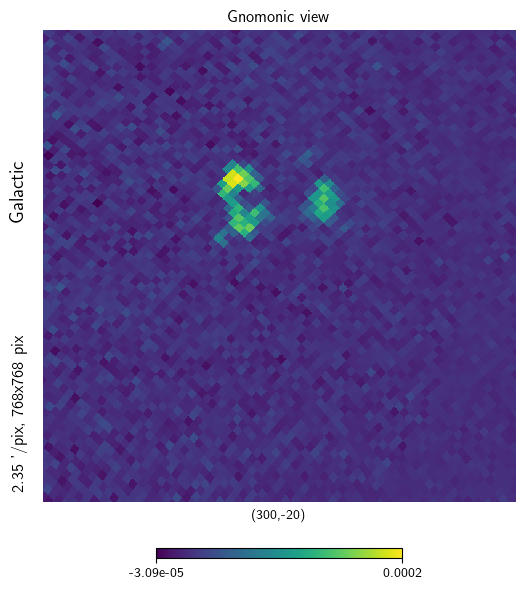

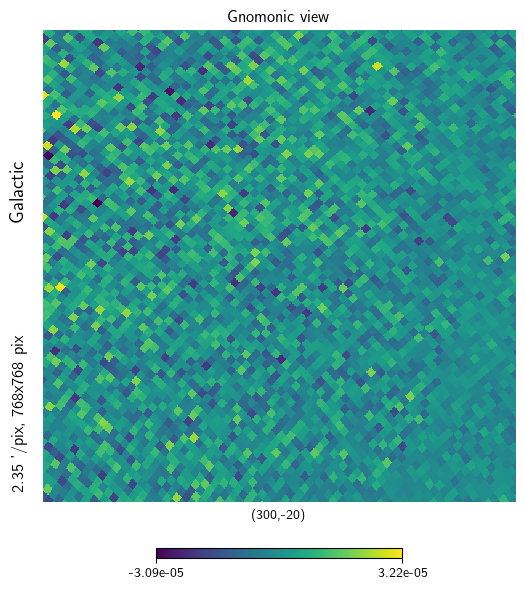

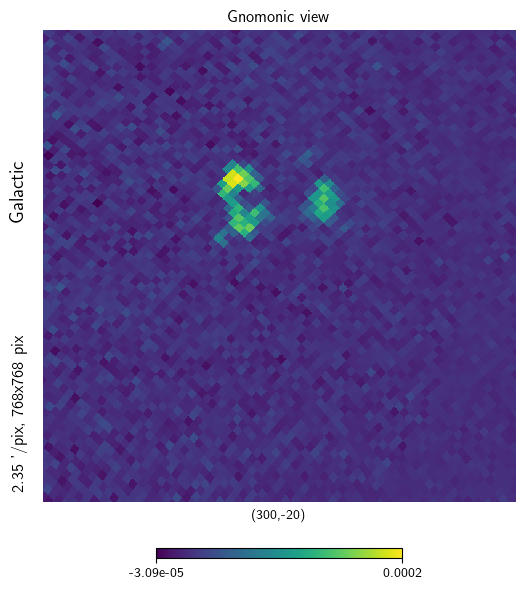

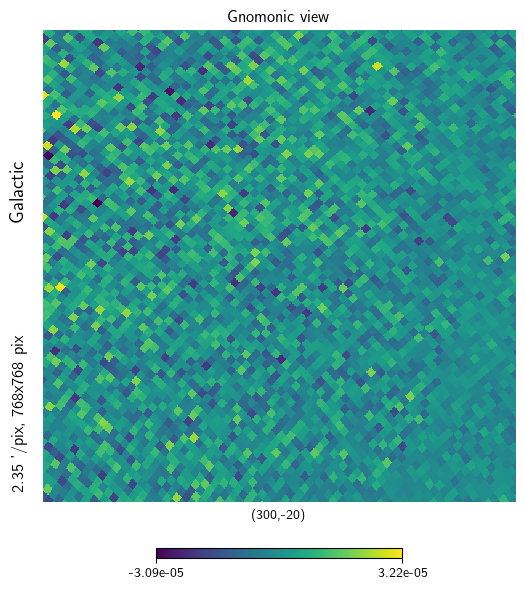

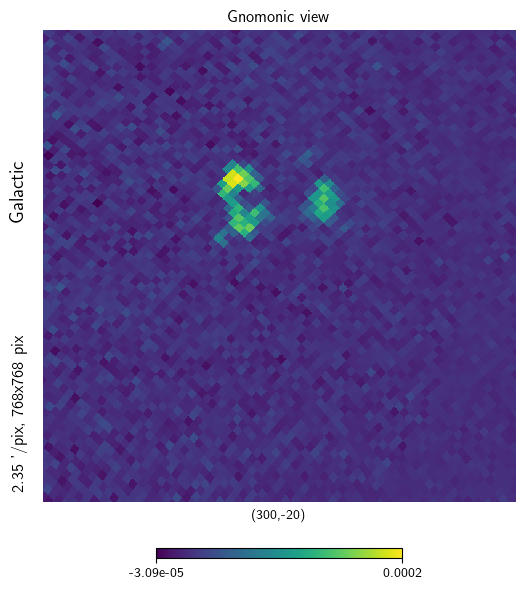

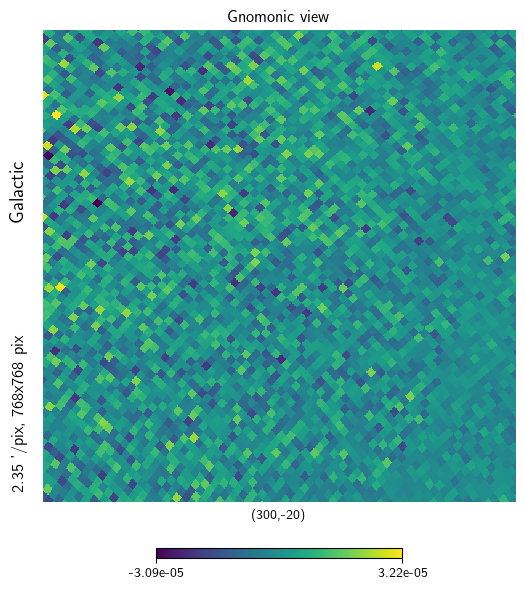

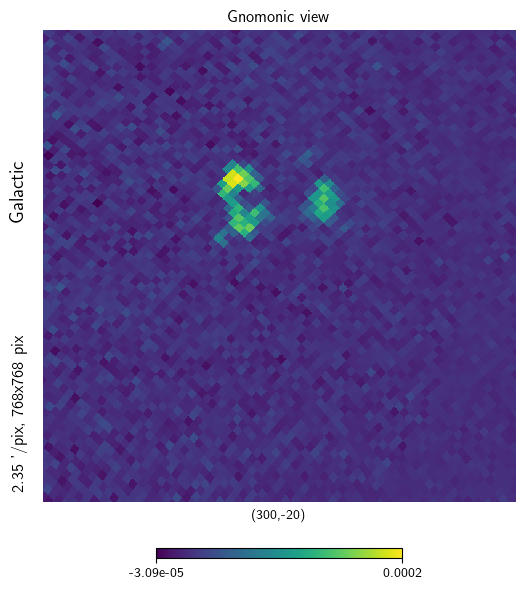

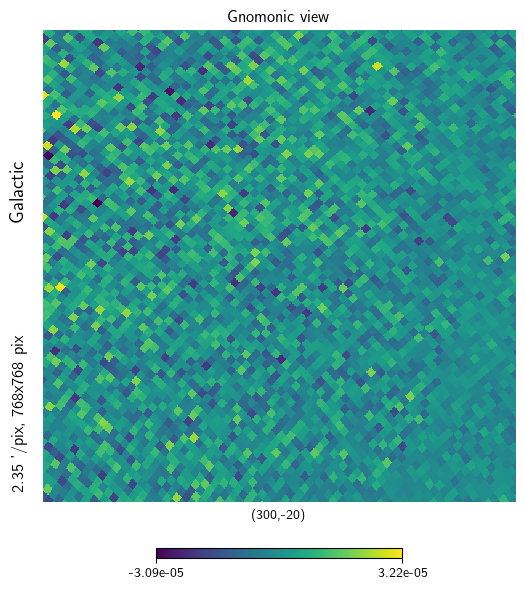

In [33]:
dir_sim = '../CO_sims/fullsky12sims/'
file_list = glob.glob(dir_sim + "/*.dat")  # This will get all files ending with .txt in the directory
file_list
noise_arrays = []
# # Now you can iterate over the file_list and do whatever you want with the files
i = 0
for file_path in file_list:
    map = np.fromfile(file_path)
    map_128 = hp.ud_grade(map0,128,order_out='RING')
    noise = map_128 - model12CO
    #s = hp.gnomview(model12CO,coord='G',rot=[glon,glat],reso=pix_arcmin,xsize=Nx,ysize=Ny,return_projected_map=True) # noiseless model: s
    d = hp.gnomview(map_128,coord='G',rot=[glon,glat],reso=pix_arcmin,xsize=Nx,ysize=Ny,return_projected_map=True) # noisy mock data: d
    d_filled = d.filled(np.nan)
    np.save('../CO_sims/d'+str(i)+'_12CO_chameleon.npy', d_filled)
    n = hp.gnomview(noise,coord='G',rot=[glon,glat],reso=pix_arcmin,xsize=Nx,ysize=Ny,return_projected_map=True) # just noise, no CO: note systematic thing there
    n_filled = n.filled(np.nan)
    np.save('../CO_sims/n'+str(i)+'_12CO_chameleon.npy', n_filled)
    array = np.load('../CO_sims/n'+str(i)+'_12CO_chameleon.npy')
    noise_arrays.append(array)
    i+=1
noise_realizations = np.stack(noise_arrays)

# Check the shape to ensure it's (n_maps, N, N)
print(noise_realizations.shape)
np.save('../CO_sims/noise_realizations_12CO_chameleon.npy', noise_realizations)


> some interesting statistical issues arise comparing amounts of model noise to data noise-- 
>
> see that the simulations are noisier than the real data, could become an issue down the line when comparing the simulations to planck map for validation
>
> see below

5.3564918485843694e-05 dif


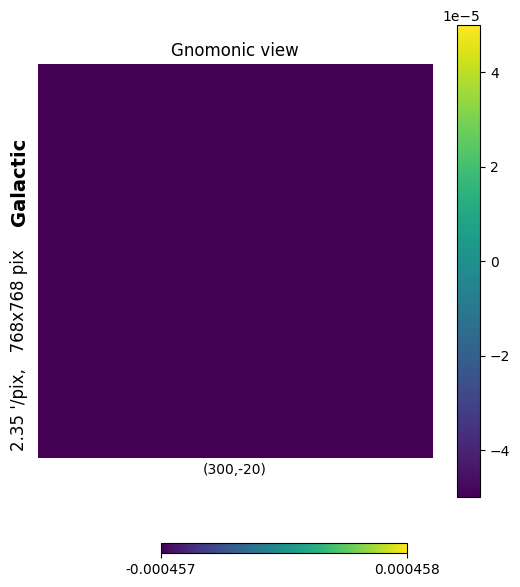

5.294587038671258e-05 mean


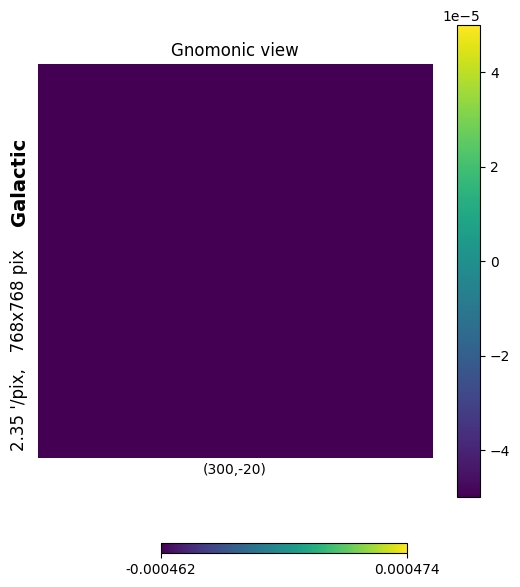

5.226257508040271e-05 map0


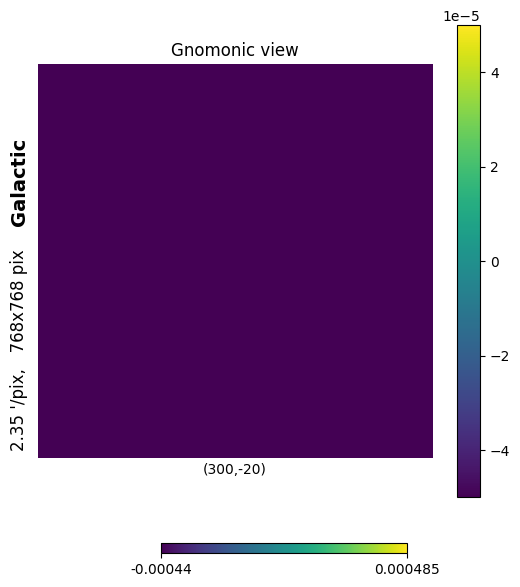

3.870156169936176e-05 planck


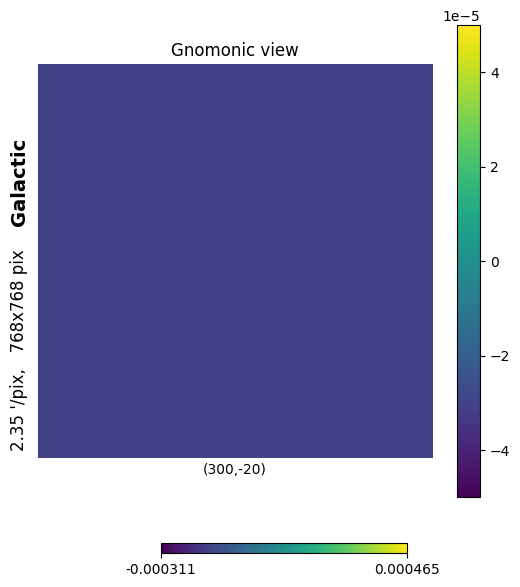

In [30]:

dif = 0.5*(map2-map1)
res= hp.gnomview(dif,coord='G',rot=[glon,glat],reso=pix_arcmin,xsize=Nx,ysize=Ny,return_projected_map=True)
print(np.std(res[0:201,468:768]),'dif')


plt.imshow(res,vmin=-5e-5,vmax=5e-5)
plt.colorbar()
plt.show()

mean = 0.5*(map2+map1)
res1= hp.gnomview(mean,coord='G',rot=[glon,glat],reso=pix_arcmin,xsize=Nx,ysize=Ny,return_projected_map=True)
print(np.std(res1[0:201,468:768]),'mean')

plt.imshow(res1,vmin=-5e-5,vmax=5e-5)
plt.colorbar()
plt.show()

res2 = hp.gnomview(map0,coord='G',rot=[glon,glat],reso=pix_arcmin,xsize=Nx,ysize=Ny,return_projected_map=True)
print(np.std(res2[0:201,468:768]),'map0')
plt.imshow(res2,vmin=-5e-5,vmax=5e-5)
plt.colorbar()
plt.show()

res3 = hp.gnomview(map_CO*fac_12CO,coord='G',rot=[glon,glat],reso=pix_arcmin,xsize=Nx,ysize=Ny,return_projected_map=True)
#res3 = hp.gnomview(map_CO*fac_12CO,coord='G',rot=[glon,glat],reso=pix_arcmin,xsize=Nx,ysize=Ny,return_projected_map=True)
#plt.imshow()
print(np.std(res3[0:201,468:768]),'planck')
plt.imshow(res3,vmin=-5e-5,vmax=5e-5)
plt.colorbar()
plt.show()